In [81]:
import os
import glob
import pandas as pd
import numpy as np
import joblib
from tqdm.notebook import tqdm
from collections import Counter
from src.ab import get_size_zratio
from p_tqdm import p_map
import matplotlib.pyplot as plt
import plotly.express as px
bayes_results = glob.glob("Experiment results/Bayesian/Experiment1/*")
result1 = bayes_results[0]


In [66]:
def create_bayes_results(filepath):
    df = joblib.load(filepath)
    params = filepath.split("/")[-1].split(r"__")
    result_df = pd.DataFrame(data=list(map(lambda x: x.split("=")[1], params))
                      ).T
    result_df.columns = list(map(lambda x: x.split("=")[0], params))
    result_df.set_index(list(map(lambda x: x.split("=")[0], params)), inplace=True)
    result_df['count_winners'] = ''
    result_df['probability_superiority_mean'] = ''
    result_df['probability_superiority_median'] = ''
    result_df['expected_losses'] = ''
    result_df['size'] = ''
    winners = [df[i][0]['probability_superiority'] for i in range(1000)]
    winners = [i if i != "not_winner" else -1 for i in winners]
    result_df.at[result_df.index[0], "count_winners"] = Counter(winners)
    result_df.at[result_df.index[0], 'probability_superiority_mean'] = np.mean(
        [df[i][1]['probability_superiority'][0] for i in range(1000)], axis=0).round(3)
    result_df.at[result_df.index[0], 'probability_superiority_median'] = np.median(
        [df[i][1]['probability_superiority'][0]  for i in range(1000)], axis=0).round(3)
#     result_df['expected_losses'] = df[i][1]['probability_superiority'][1].round(5)
    result_df['size'] = df[0][1]['probability_superiority'][2]
    return result_df
filepathes = glob.glob("Experiment results/Bayesian/Experiment1/*")
bayes_results_df = p_map(create_bayes_results, filepathes)
bayes_results_df = pd.concat(bayes_results_df)

  0%|          | 0/270 [00:00<?, ?it/s]

In [67]:
bayes_results_df.sort_values("size")

count_winners  \
p_control mde prob_super                              
5         0   0.8         {-1: 605, 1: 199, 0: 196}   
9         0   0.8         {0: 194, -1: 624, 1: 182}   
3         0   0.99          {-1: 980, 0: 10, 1: 10}   
7         0   0.8         {-1: 603, 0: 201, 1: 196}   
5         0   0.85        {-1: 704, 0: 154, 1: 142}   
...                                             ...   
1         2   0.9                  {1: 937, -1: 63}   
              0.95                {1: 893, -1: 107}   
              0.99                {1: 721, -1: 279}   
              0.85                 {1: 959, -1: 41}   
              0.8                  {1: 974, -1: 26}   

                         probability_superiority_mean  \
p_control mde prob_super                                
5         0   0.8                      [0.499, 0.501]   
9         0   0.8                      [0.507, 0.493]   
3         0   0.99                     [0.494, 0.506]   
7         0   0.8                      [0.502, 0.498]   
5         0   0.85                     [0.499, 0.501]   
...                                               ...   
1         2   0.9                      [0.023, 0.977]   
              0.95                     [0.023, 0.977]   
              0.99                     [0.023, 0.977]   
              0.85                     [0.023, 0.977]   
              0.8                      [0.023, 0.977]   

                         probability_superiority_median expected_losses  \
p_control mde prob_super                                                  
5         0   0.8                            [0.5, 0.5]                   
9         0   0.8                          [0.51, 0.49]                   
3         0   0.99                       [0.483, 0.517]                   
7         0   0.8                            [0.5, 0.5]                   
5         0   0.85                           [0.5, 0.5]                   
...                                                 ...             ...   
1         2   0.9                        [0.002, 0.998]                   
              0.95                       [0.002, 0.998]                   
              0.99                       [0.002, 0.998]                   
              0.85                       [0.002, 0.998]                   
              0.8                        [0.002, 0.998]                   

                             size  
p_control mde prob_super           
5         0   0.8           10000  
9         0   0.8           10000  
3         0   0.99          10000  
7         0   0.8           10000  
5         0   0.85          10000  
...                           ...  
1         2   0.9         3923647  
              0.95        3923647  
              0.99        3923647  
              0.85        3923647  
              0.8         3923647  

[270 rows x 5 columns]

In [73]:
def create_thompson_results(filepath):
    df = joblib.load(filepath)
    params = filepath.split("/")[-1].split(r"__")
    result_df = pd.DataFrame(data=list(map(lambda x: x.split("=")[1], params))
                          ).T
    result_df.columns = list(map(lambda x: x.split("=")[0], params))
    result_df.set_index(list(map(lambda x: x.split("=")[0], params)), inplace=True)
    result_df['count_winners'] = ''
    result_df.at[result_df.index[0], "count_winners"] = Counter([df[i][0]['probability_superiority'] 
                                                                 for i in range(1000)])
    # Get share observations out of needed

    p_control = int(result_df.index.levels[1].values[0])
    mde = int(result_df.index.levels[1].values[0])
    result_df['size'] = ''
    result_df.loc[result_df.index[0], 'size'] = get_size_zratio(p_control, mde, 0.05, 0.2)
    shares = tuple(np.cumsum(df[i][1]['probability_superiority'][2], axis=0)[-1] / result_df['size'].values[0]
              for i in range(1000))
    result_df['share_observations_mean'] = ''
    result_df['share_observations_median'] = ''
    result_df.at[result_df.index[0], 'share_observations_mean'] = np.mean(shares, axis=0).round(3)
    result_df.at[result_df.index[0], 'share_observations_median'] = np.median(shares, axis=0).round(3)

    # Add share correct / incorrect winners
    result_df['share_test_winner'] = result_df['count_winners']\
                                        .apply(lambda x: x[1] / 1000)
    result_df['share_not_winner'] = result_df['count_winners']\
                                        .apply(lambda x: x[-1] / 1000)
    result_df['share_control_winner'] = result_df['count_winners']\
                                        .apply(lambda x: x[0] / 1000)
    return result_df
filepathes = glob.glob("/home/igor/Appbooster/proba.ai/AB/Experiment results/Thompson/Experiment1/*")
thompson_results_df = p_map(create_thompson_results, filepathes)
thompson_results_df = pd.concat(thompson_results_df)

  0%|          | 0/900 [00:00<?, ?it/s]

In [94]:
thompson_results_df

count_winners  \
p_control mde prob_super batch_size_share_mu multi_armed                              
11        5   0.99       0.01                True         {0: 243, 1: 519, -1: 238}   
          0   0.95       0.08                True         {-1: 442, 1: 284, 0: 274}   
6         5   0.99       0.01                True         {1: 552, -1: 215, 0: 233}   
1         10  0.99       0.04                True          {1: 563, 0: 78, -1: 359}   
                         0.09                False         {1: 587, -1: 396, 0: 17}   
...                                                                             ...   
6         0   0.9        0.02                False        {-1: 149, 1: 426, 0: 425}   
1         10  0.95       0.01                False        {1: 572, -1: 160, 0: 268}   
          0   0.99       0.08                False        {-1: 623, 1: 196, 0: 181}   
11        10  0.85       0.1                 True          {1: 793, -1: 147, 0: 60}   
6         5   0.9        0.01                False        {1: 603, 0: 290, -1: 107}   

                                                            size  \
p_control mde prob_super batch_size_share_mu multi_armed           
11        5   0.99       0.01                True         122120   
          0   0.95       0.08                True          10000   
6         5   0.99       0.01                True         122120   
1         10  0.99       0.04                True          14748   
                         0.09                False         14748   
...                                                          ...   
6         0   0.9        0.02                False         10000   
1         10  0.95       0.01                False         14748   
          0   0.99       0.08                False         10000   
11        10  0.85       0.1                 True          14748   
6         5   0.9        0.01                False        122120   

                                                         share_observations_mean  \
p_control mde prob_super batch_size_share_mu multi_armed                           
11        5   0.99       0.01                True                 [0.319, 0.326]   
          0   0.95       0.08                True                 [1.186, 1.192]   
6         5   0.99       0.01                True                 [0.601, 0.617]   
1         10  0.99       0.04                True               [10.872, 12.232]   
                         0.09                False              [14.313, 14.313]   
...                                                                          ...   
6         0   0.9        0.02                False                [0.583, 0.583]   
1         10  0.95       0.01                False                [6.652, 6.652]   
          0   0.99       0.08                False                [1.655, 1.655]   
11        10  0.85       0.1                 True                 [0.493, 0.552]   
6         5   0.9        0.01                False                [0.327, 0.327]   

                                                         share_observations_median  \
p_control mde prob_super batch_size_share_mu multi_armed                             
11        5   0.99       0.01                True                   [0.149, 0.154]   
          0   0.95       0.08                True                    [1.361, 1.32]   
6         5   0.99       0.01                True                   [0.294, 0.313]   
1         10  0.99       0.04                True                  [9.829, 11.994]   
                         0.09                False                  [14.15, 14.15]   
...                                                                            ...   
6         0   0.9        0.02                False                  [0.212, 0.212]   
1         10  0.95       0.01                False                  [2.185, 2.185]   
          0   0.99       0.08                False                  [2.017, 2.017]   
11        10  

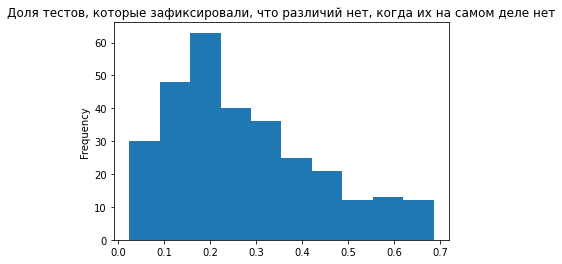

In [80]:
thompson_results_df.query("mde == '0'")['share_not_winner'].plot(kind='hist');
plt.title("Доля тестов, которые зафиксировали, что различий нет, когда их на самом деле нет");

In [95]:
plot_df = thompson_results_df.query("""mde == '0' & multi_armed == 'True'""").reset_index()[
    ['share_not_winner', "prob_super",'batch_size_share_mu']].astype(float)
fig = px.scatter(plot_df, x="share_not_winner", y="prob_super", color="batch_size_share_mu")
fig.show()

In [103]:
plot_df = thompson_results_df.query("""mde != '0' & multi_armed == 'False'""").reset_index()[
    ["share_not_winner", 'share_test_winner', "prob_super",'batch_size_share_mu']].astype(float)
fig = px.scatter(plot_df, x="share_test_winner", y="prob_super", color="batch_size_share_mu")
fig.show()

In [115]:
np.random.normal([0, 0, 0], [1,1,1], size=(1000000, 3))

array([[-2.4148056 ,  0.36092571,  0.65345072],
       [-0.26712527,  1.00968113, -0.87349141],
       [-0.16544407,  0.36360063, -1.12730837],
       ...,
       [ 1.27795096, -0.31788402,  0.5742638 ],
       [-0.16100329, -0.48707012,  0.07284455],
       [-0.44844991,  0.81755284, -1.19668403]])

In [116]:
df = pd.DataFrame(np.random.normal([0, 0, 0], [1,1,1], size=(1000000, 3)))
df

,0,1,2
0,1.598177,0.435866,-1.167836
1,-0.195492,1.399399,0.805820
2,-1.207047,0.027457,1.487354
3,0.114443,-0.672164,-0.031030
4,-0.228223,-0.029119,-0.472397
...,...,...,...
999995,-1.431599,-0.686605,0.266487
999996,1.084150,-0.267332,-0.281608
999997,0.814755,1.240877,-0.530982
999998,1.475574,-1.125270,-0.486181


In [118]:
%timeit df[0].apply(lambda x: (x ** 100) / 1500)

221 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
import swifter
%timeit df[0].swifter.apply(lambda x: (x ** 100) / 1500)

17.7 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Костыльное решение (фиксим, разделяя __)
p_control_list = [0.1, 0.2, 0.3, 0.4, 0.5]
mde_list = np.linspace(0.01, 0.5, 10)
# result_experiments_df = pd.DataFrame(index=pd.MultiIndex.from_product(
#                                      [p_control_list, mde_list],
#                                      names=["distr_type", "mean_control", "mde_test_effect",
#                                             "sigma_control", "sigma_diff", "size"]),
#                                      columns=['p_value_Student', 'p_value_MU', 'p_value_BS',
#                                               "control_bs_means", "test_bs_means"])

In [ ]:
import joblib
df = joblib.load("/home/igor/Appbooster/proba.ai/AB/Experiment results/Bayesian/Experiment1/p_control=1__mde=0__prob_super=0.8")

In [ ]:
# files = glob.glob('Experiment results/Bayesian/Experiment1/*')
# for f in files:
#     os.remove(f)